<a href="https://colab.research.google.com/github/stojatesanovic/Google_Stock_Prediction_LSTM/blob/main/Google_Stock_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from tabulate import tabulate
from copy import deepcopy
import datetime

googl_data = yf.download('GOOGL', start='2004-08-19', end='2024-08-19')

googl_data.to_csv('GOOGL.csv')

df = pd.read_csv('GOOGL.csv')
df.tail()


[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
5028,2024-08-12,164.350006,164.899994,161.839996,162.289993,162.074921,15895300
5029,2024-08-13,163.410004,164.729996,162.970001,164.160004,163.942459,18551700
5030,2024-08-14,162.399994,163.220001,157.710007,160.369995,160.157471,40591100
5031,2024-08-15,160.500000,161.639999,159.610001,161.300003,161.086243,31524300
5032,2024-08-16,161.470001,165.059998,161.130005,162.960007,162.744049,24208600


For the purpose of the research, we will use only the value at the end of the day. Therefore, from the entire table, we are selecting only the 'Date' and 'Close' columns

In [ ]:
df = df[['Date', 'Close']]

df

,Date,Close
0,2004-08-19,2.511011
1,2004-08-20,2.710460
2,2004-08-23,2.737738
3,2004-08-24,2.624374
4,2004-08-25,2.652653
...,...,...
5028,2024-08-12,162.289993
5029,2024-08-13,164.160004
5030,2024-08-14,160.369995
5031,2024-08-15,161.300003


In [ ]:
df['Date']

,Date
0,2004-08-19
1,2004-08-20
2,2004-08-23
3,2004-08-24
4,2004-08-25
...,...
5028,2024-08-12
5029,2024-08-13
5030,2024-08-14
5031,2024-08-15


Since the values for the date are not of the correct type, we need to convert them to the appropriate type

In [ ]:
def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

datetime_object = str_to_datetime('2004-08-19')
datetime_object

datetime.datetime(2004, 8, 19, 0, 0)

In [ ]:
df

,Date,Close
0,2004-08-19,2.511011
1,2004-08-20,2.710460
2,2004-08-23,2.737738
3,2004-08-24,2.624374
4,2004-08-25,2.652653
...,...,...
5028,2024-08-12,162.289993
5029,2024-08-13,164.160004
5030,2024-08-14,160.369995
5031,2024-08-15,161.300003


In [ ]:
df['Date'] = df['Date'].apply(str_to_datetime)
df['Date']

,Date
0,2004-08-19
1,2004-08-20
2,2004-08-23
3,2004-08-24
4,2004-08-25
...,...
5028,2024-08-12
5029,2024-08-13
5030,2024-08-14
5031,2024-08-15


In [ ]:
df.index = df.pop('Date')
df

,Close
Date,
2004-08-19,2.511011
2004-08-20,2.710460
2004-08-23,2.737738
2004-08-24,2.624374
2004-08-25,2.652653
...,...
2024-08-12,162.289993
2024-08-13,164.160004
2024-08-14,160.369995


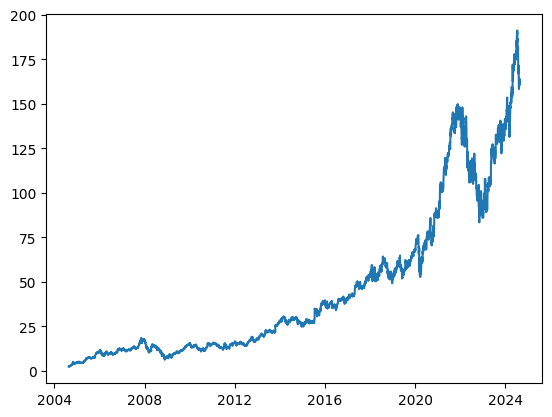

In [ ]:
plt.plot(df.index, df['Close'])

For the purpose of constructing the model, we are creating a sliding window of values for each date. The 'Target' column will hold the value for the current date, while the preceding 3 days' values will be captured in 'Target-1', 'Target-2' and 'Target-3'. This ensures that for every 'Target' value, the model has access to the previous 3 days' data to inform its predictions. Initially, we used date #1 as the starting point, but due to significant market fluctuations starting in 2020, we decided to use date #2 as the beginning of the testing period

In [ ]:
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date

  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)

    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

    if last_time:
      break

    target_date = next_date

    if target_date == last_date:
      last_time = True

  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates

  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]

  ret_df['Target'] = Y

  return ret_df

#1 start - 2004-09-01
#2 start - 2020-03-25
windowed_df = df_to_windowed_df(df,
                                '2020-03-25',
                                '2024-08-01',
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2020-03-25,53.410500,52.706501,56.500500,55.081001
1,2020-03-26,52.706501,56.500500,55.081001,58.146000
2,2020-03-27,56.500500,55.081001,58.146000,55.513000
3,2020-03-30,55.081001,58.146000,55.513000,57.315498
4,2020-03-31,58.146000,55.513000,57.315498,58.097500
...,...,...,...,...,...
1091,2024-07-26,181.789993,172.630005,167.279999,167.000000
1092,2024-07-29,172.630005,167.279999,167.000000,169.529999
1093,2024-07-30,167.279999,167.000000,169.529999,170.289993
1094,2024-07-31,167.000000,169.529999,170.289993,171.539993


In [ ]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((1096,), (1096, 3, 1), (1096,))

We are using 80% of the data for training, 10% for validation and 10% for testing

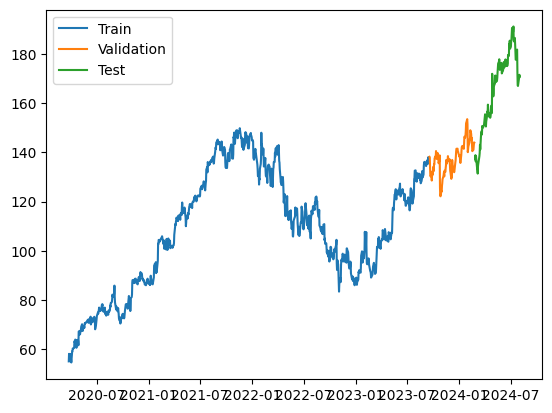

In [ ]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

We're building a sequential model using TensorFlow/Keras to predict stock prices based on the past three days’ values. The model starts with an LSTM layer of 64 units to capture patterns over time, followed by a dropout layer with a 50% rate to help prevent overfitting. Then, we’ve added two dense layers, each with 32 units and ReLU activation, to process the learned features. The final layer is a single neuron that outputs the predicted value. We're using mean squared error (MSE) as the loss function and Adam as the optimizer with a learning rate of 0.001. The model is trained for 100 epochs, with 80% of the data used for training and 10% each for validation and testing

In [ ]:
model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    Dropout(0.5),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)



Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 12414.7832 - mean_absolute_error: 108.8675 - val_loss: 18502.3359 - val_mean_absolute_error: 135.8703
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 11886.1143 - mean_absolute_error: 106.4562 - val_loss: 16037.1797 - val_mean_absolute_error: 126.4722
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8793.6455 - mean_absolute_error: 90.1366 - val_loss: 7551.2637 - val_mean_absolute_error: 86.6376
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2400.1912 - mean_absolute_error: 41.8299 - val_loss: 787.9170 - val_mean_absolute_error: 27.3211
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 809.4533 - mean_absolute_error: 23.5070 - val_loss: 957.8711 - val_mean_absolute_error: 30.2740
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 781.0083 - mean_absolute_error: 22.9096 - val_loss: 1010.2020 - val_mean_absolute_error: 31.2119
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step -

## Training Predictions/Observations

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


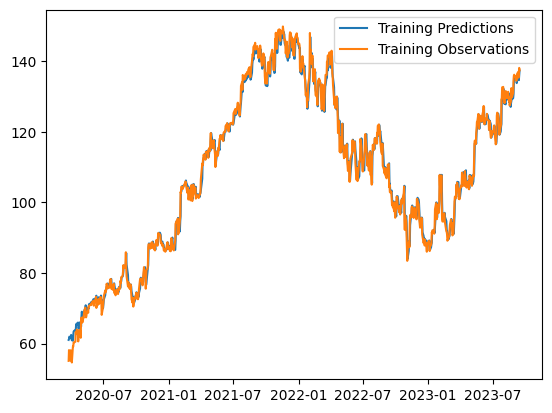

In [ ]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

## Validation Predictions/Observations

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


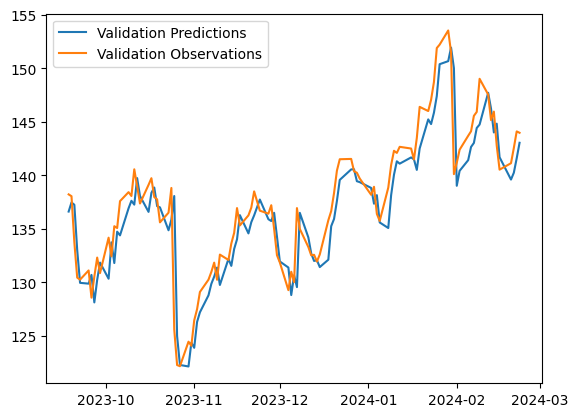

In [ ]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

## Testing Predictions/Observations

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


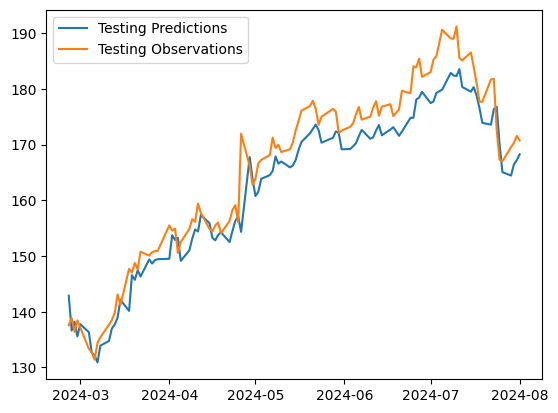

In [ ]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

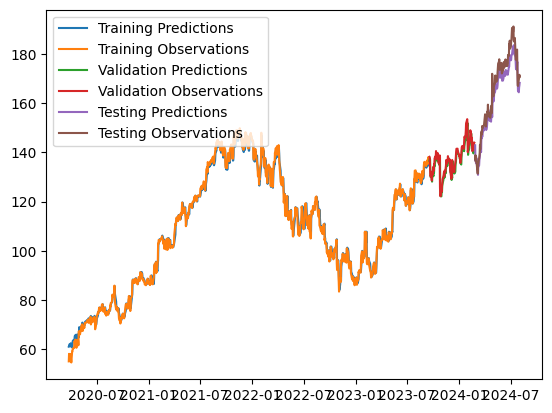

In [ ]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])

Now we will make a model that makes predictions iteratively, using each prediction to inform the next one. For each date in the validation and test sets, the model predicts the next value based on the most recent data. After each prediction, the model updates the input with the predicted value, creating a recursive loop where each prediction is based on the previous one

In [ ]:
recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━

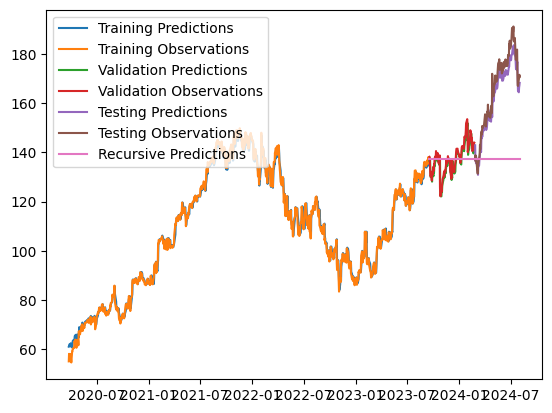

In [ ]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations',
            'Recursive Predictions'])

As we can see from the graph, predicting future values is almost impossible, because the model will always rely on the previous day's values. Since it won't know the actual future values, this creates a situation where the model will continue to predict the same value repeatedly

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Mean Squared Error (MSE): 20.256561279296875
Mean Absolute Error (MAE): 3.715792655944824
Root Mean Squared Error (RMSE): 4.500729084014893
Mean Absolute Percentage Error (MAPE): 10.62%
Model Success Percentage: 89.38%


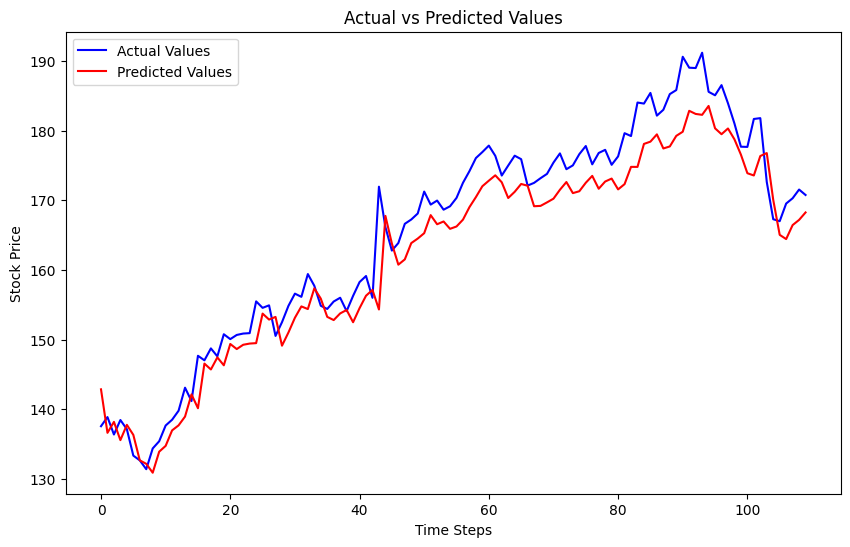

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

predictions = model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mse)

mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100

accuracy = 100 - mape

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Model Success Percentage: {accuracy:.2f}%")

plt.figure(figsize=(10,6))
plt.plot(y_test, label='Actual Values', color='blue')
plt.plot(predictions, label='Predicted Values', color='red')
plt.title("Actual vs Predicted Values")
plt.xlabel("Time Steps")
plt.ylabel("Stock Price")
plt.legend()
plt.show()
